# HACKtheMACHINE

-------

### TRACK 2 - Data Science & the Seven Seas: Collision Avoidance - https://www.hackthemachine.ai/track2/

-------

__*Challenge 1: Identifying COLREGS Interactions*__

- Out of the billions of data points in the AIS dataset can you find the most efficient algorithm to identify potential COLREGS interactions?

__*Challenge 2: Contextualizing COLREGS Interactions*__

- COLREGS are complicated and multifactorial. Can you apply contextual awareness to encounters between ships in order to help the Navy develop models for what constitutes “normal” behavior at sea?

-------

This analysis utilizes Automated Information Systems (AIS) data from the month of July in 2017 for Zone 11, which is off the Pacific Ocean near Southern California and the Baja Peninsula.  The entire month includes almost 13 million records representing the location, course/heading, speed, and some additional attributes of 2,836 unique vessels.  A subset of the data for the day of July 1, 2017, which containes 407,845 records, is used below.

-------

## General Approach

A multi-stage approach is used for identification and categorization of potential ship collisions:
1. Identify pairs of ships that are near in time and space
2. Identify potential collisions based on the speed and course (direction) of nearby pairs of ships
3. Categorize potential collisions by type of interaction:
    -  vessels approaching head-on
    -  one vessel overtaking another
    -  one vessel having the right-of-way in a crossing situation
    
-------

In __Step 1__, data is normalized by LON/LAT and time so that a unitless distance of 1 represents a user-defined distance threshold that separates "near" from "far" points (this analysis uses 4 nautical miles and 120 seconds).  A k-d tree is then created from normalized LON/LAT and time, which is queried to efficiently identify pairs of vessels that are near one another.

__Step 2__ identifies ships that will collide if no change in speed or direction occurs by determining whether there is a future time t for which the LON/LAT of the two ships will be identical.  In this step, the original Pandas DataFrame is converted to a Numpy matrix to efficiently access the position, speed, and direction of the two nearby ships, and a vectorized calculation is performed to identify whether there is a future time t for which the two ships share the same LON/LAT position.

__Step 3__ categorizes interaction type based on the difference in angle of approach for the two vessels.

-------

In [1]:
# import packages
import os, io, glob, requests, zipfile
import pandas as pd
import numpy as np
import datetime as dt
import geopandas
import pickle
import math
import random
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
start_analysis_time = dt.datetime.now()
start_analysis_time

datetime.datetime(2018, 9, 27, 15, 29, 6, 432467)

### download, unzip, and read data

In [4]:
def download_ais_data(year, month, zone, data_dir='./data'):
    '''function to download ais data from https://marinecadastre.gov/ais/ and return corresponding pandas dataframe'''
    # import packages
    import os, io, requests, zipfile
    import pandas as pd
    
    # create data directory
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # create path to csv file
    csv_file = 'AIS_{}_{}_Zone{}.csv'.format(year, str(month).zfill(2), str(zone).zfill(2))
    csv_path = os.path.join(data_dir, 'AIS_ASCII_by_UTM_Month', str(year), csv_file)
        
    try:
        # read csv if already downloaded
        data = pd.read_csv(csv_path)
    except:
        # create zip file url
        zip_file_url = ('https://coast.noaa.gov/htdata/CMSP/AISDataHandler/'
                        '{}/AIS_{}_{}_Zone{}.zip'.format(year, year, 
                                                         str(month).zfill(2), 
                                                         str(zone).zfill(2)))
        # download and extract data
        r = requests.get(zip_file_url, stream=True)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(data_dir)

        # load csv as dataframe
        data = pd.read_csv(csv_path)

    return data

In [5]:
# download data for Zone 11 in July 2017
data1month = download_ais_data(year=2017, month=7, zone=11)

### Some simple data exploration

In [6]:
data1month.shape

(12776834, 16)

In [7]:
data1month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12776834 entries, 0 to 12776833
Data columns (total 16 columns):
MMSI            int64
BaseDateTime    object
LAT             float64
LON             float64
SOG             float64
COG             float64
Heading         float64
VesselName      object
IMO             object
CallSign        object
VesselType      float64
Status          object
Length          float64
Width           float64
Draft           float64
Cargo           float64
dtypes: float64(10), int64(1), object(5)
memory usage: 1.5+ GB


In [8]:
data1month.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,367302530,2017-07-01T00:00:05,33.73642,-118.26988,0.0,-49.6,511.0,NaN,NaN,NaN,NaN,under way using engine,NaN,NaN,NaN,NaN
1,366970120,2017-07-01T00:00:05,32.69319,-117.15330,10.6,-92.7,511.0,ADMIRAL HORNBLOWER,NaN,WSQ7555,1012.0,under way using engine,43.04,12.3,NaN,NaN
2,345066014,2017-07-01T00:00:12,32.67881,-117.12578,0.1,-85.4,511.0,NaN,NaN,NaN,NaN,undefined,NaN,NaN,NaN,NaN
3,338107334,2017-07-01T00:00:17,32.74433,-118.26710,18.0,-109.2,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,338181008,2017-07-01T00:00:54,33.71416,-118.06256,0.0,-157.6,511.0,JANICE O,NaN,NaN,1019.0,NaN,15.18,NaN,NaN,NaN


In [9]:
# check unique and null values
print('out of {} total records...'.format(data1month.shape[0]))
for col in data1month.columns:
    unique_values = len(data1month[col].unique())
    pct_unique = unique_values / data1month.shape[0] * 100
    null_values = data1month[col].isnull().sum()
    pct_null = null_values / data1month.shape[0] * 100
    print('{} has {} unique values ({:.1f}%) and {} null values ({:.1f}%)'.format(col, unique_values, pct_unique, 
                                                                        null_values, pct_null))

out of 12776834 total records...
MMSI has 2836 unique values (0.0%) and 0 null values (0.0%)
BaseDateTime has 2646075 unique values (20.7%) and 0 null values (0.0%)
LAT has 936581 unique values (7.3%) and 0 null values (0.0%)
LON has 568103 unique values (4.4%) and 0 null values (0.0%)
SOG has 618 unique values (0.0%) and 0 null values (0.0%)
COG has 3603 unique values (0.0%) and 0 null values (0.0%)
Heading has 364 unique values (0.0%) and 0 null values (0.0%)
VesselName has 2492 unique values (0.0%) and 765499 null values (6.0%)
IMO has 1120 unique values (0.0%) and 8122851 null values (63.6%)
CallSign has 1906 unique values (0.0%) and 3250347 null values (25.4%)
VesselType has 39 unique values (0.0%) and 1390742 null values (10.9%)
Status has 14 unique values (0.0%) and 4594802 null values (36.0%)
Length has 993 unique values (0.0%) and 2683681 null values (21.0%)
Width has 343 unique values (0.0%) and 4866460 null values (38.1%)
Draft has 144 unique values (0.0%) and 9031521 null v

In [10]:
# grouping by MMSI and counting number of unique vessel names yields max of 1
# (so we can assume MMSI is proxy for vessel name)
data1month.groupby(by='MMSI')['VesselName'].nunique().max()

1

### Optionally subset data down to various smaller sizes
- 1 month (July 2017) ~ 12.8M records
- 1 day (July 1, 2017) ~ 400k records
- 1 hour (July 1, 2017, 6-7pm) ~ 20k records
- 10 min (July 1, 2017, 6:00-6:10pm) ~ 3k records

In [11]:
%%time

# convert timestamps to datetime
data1month['BaseDateTime'] = pd.to_datetime(data1month['BaseDateTime'])

CPU times: user 3.15 s, sys: 171 ms, total: 3.32 s
Wall time: 3.3 s


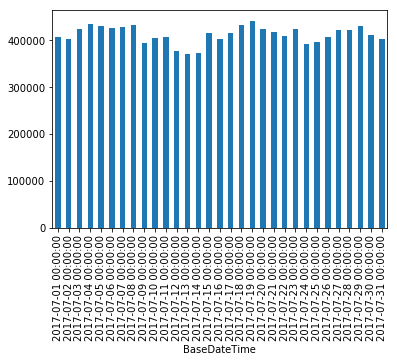

In [12]:
# plot count of MMSI by day
data1month.groupby(pd.Grouper(key='BaseDateTime', freq='D'))['MMSI'].count().plot(kind='bar');

In [13]:
# subset data to single day
data1day = data1month[(data1month['BaseDateTime']>dt.datetime(2017,7,1)) & 
                      (data1month['BaseDateTime']<dt.datetime(2017,7,2))].copy()

data1day.shape

(407845, 16)

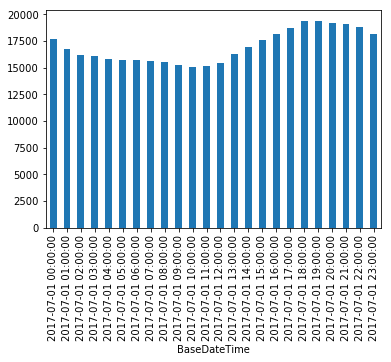

In [14]:
# plot count of MMSI in 1 hour intervals
data1day.groupby(pd.Grouper(key='BaseDateTime', freq='1h'))['MMSI'].count().plot(kind='bar');

In [15]:
data1hour = data1day[(data1day['BaseDateTime'] > dt.datetime(2017,7,1,18)) & 
                     (data1day['BaseDateTime'] < dt.datetime(2017,7,1,19))].copy()

data1hour.shape

(19352, 16)

In [16]:
data10mins = data1hour[(data1hour['BaseDateTime'] > dt.datetime(2017,7,1,18,0)) & 
                       (data1hour['BaseDateTime'] < dt.datetime(2017,7,1,18,10))].copy()

data10mins.shape

(3158, 16)

# Step 1
### Finding Nearby Ships in Time and Space Using SciPy KDTrees

Detailed approach:

1. convert BaseDateTime to timedelta in seconds from earliest timestamp in data
2. convert LAT to delta from min LAT and convert to nautical miles from min LAT
3. convert LON to delta from min LON and convert to nautical miles from min LON (assume LAT is max abs LAT from data)
4. normalize timedeltas by dividing by 120 seconds (or different timedelta threshold if desired)
5. normalize nautical miles from min LAT/LON by dividing by 4 n.m. (or different distance threshold if desired)
6. construct KDTree from normalized distance data
7. query KDTree for pairs of points within a distance of 1 unit (normalized time/LAT/LON distances)

Info on converting LAT/LON to nautical miles:
https://astronavigationdemystified.com/the-relationships-between-longitude-and-latitude-and-the-nautical-mile/

Resource to check distance between points by LON/LAT:
https://www.nhc.noaa.gov/gccalc.shtml

In [17]:
from scipy.spatial import cKDTree

In [18]:
data = data1day.reset_index(drop=True).copy()

In [19]:
data.shape

(407845, 16)

In [20]:
data.head(2)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,367302530,2017-07-01 00:00:05,33.73642,-118.26988,0.0,-49.6,511.0,NaN,NaN,NaN,NaN,under way using engine,NaN,NaN,NaN,NaN
1,366970120,2017-07-01 00:00:05,32.69319,-117.15330,10.6,-92.7,511.0,ADMIRAL HORNBLOWER,NaN,WSQ7555,1012.0,under way using engine,43.04,12.3,NaN,NaN


In [21]:
# create the dataframe we will used to normalize data and perform analysis
kdt_df = data[['MMSI','BaseDateTime','LAT','LON','SOG','COG']].copy()
kdt_df.head(2)

,MMSI,BaseDateTime,LAT,LON,SOG,COG
0,367302530,2017-07-01 00:00:05,33.73642,-118.26988,0.0,-49.6
1,366970120,2017-07-01 00:00:05,32.69319,-117.15330,10.6,-92.7


In [22]:
# convert time to seconds since earliest timestamp
min_time_from_data = kdt_df['BaseDateTime'].min()
max_time_from_data = kdt_df['BaseDateTime'].max()

min_time_from_data, max_time_from_data

(Timestamp('2017-07-01 00:00:01'), Timestamp('2017-07-01 23:59:59'))

In [23]:
# function to normalize time to a unitless distance metric based on a time threshold
def convert_ts_to_time_dist(df_row, min_time=min_time_from_data, time_threshold=pd.Timedelta('120 s')):
    '''function to convert timestamp to timedelta based on min_time'''
    return (df_row['BaseDateTime'] - min_time) / time_threshold

In [24]:
%%time

kdt_df['time_norm'] = kdt_df.apply(convert_ts_to_time_dist, axis=1)

CPU times: user 46.5 s, sys: 164 ms, total: 46.6 s
Wall time: 46.7 s


In [25]:
kdt_df.head(2)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,time_norm
0,367302530,2017-07-01 00:00:05,33.73642,-118.26988,0.0,-49.6,0.033333
1,366970120,2017-07-01 00:00:05,32.69319,-117.15330,10.6,-92.7,0.033333


In [26]:
# convert LAT to delta from min LAT
min_LAT_from_data = kdt_df['LAT'].min()
max_LAT_from_data = kdt_df['LAT'].max()
min_LAT_from_data, max_LAT_from_data

(20.53717, 46.70026)

In [27]:
# function to normalize LAT to unitless distance metric 
nm_for_1_degree_diff_in_LAT = 60

def convert_LAT_to_nm_dist(df_row, min_LAT=min_LAT_from_data, nm_dist_threshold=4):
    '''function to convert LAT to nautical miles delta'''
    return ((df_row['LAT'] - min_LAT) * nm_for_1_degree_diff_in_LAT) / nm_dist_threshold

In [28]:
%%time

kdt_df['LAT_norm'] = kdt_df.apply(convert_LAT_to_nm_dist, axis=1)

CPU times: user 33.8 s, sys: 196 ms, total: 34 s
Wall time: 34.1 s


In [29]:
kdt_df.head(2)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,time_norm,LAT_norm
0,367302530,2017-07-01 00:00:05,33.73642,-118.26988,0.0,-49.6,0.033333,197.98875
1,366970120,2017-07-01 00:00:05,32.69319,-117.15330,10.6,-92.7,0.033333,182.34030


In [30]:
# determine distance in nautical miles for 1 degree difference in LON
min_LON_from_data = kdt_df['LON'].min()
max_abs_LAT_from_data = kdt_df['LAT'].abs().max()
min_LON_from_data, max_abs_LAT_from_data

(-119.99983, 46.70026)

In [31]:
# function to normalize LON to unitless distance metric
nm_for_1_degree_diff_in_LON = math.cos(max_abs_LAT_from_data * math.pi/180) * 60

def convert_LON_to_nm_dist(df_row, min_LON=min_LON_from_data, nm_dist_threshold=4):
    '''function to convert LON to nautical miles delta'''
    return ((df_row['LON'] - min_LON) * nm_for_1_degree_diff_in_LON) / nm_dist_threshold

In [32]:
%%time

kdt_df['LON_norm'] = kdt_df.apply(convert_LON_to_nm_dist, axis=1)

CPU times: user 33.5 s, sys: 171 ms, total: 33.7 s
Wall time: 33.7 s


In [33]:
kdt_df.head(2)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,time_norm,LAT_norm,LON_norm
0,367302530,2017-07-01 00:00:05,33.73642,-118.26988,0.0,-49.6,0.033333,197.98875,17.796386
1,366970120,2017-07-01 00:00:05,32.69319,-117.15330,10.6,-92.7,0.033333,182.34030,29.282897


In [34]:
kdt_df.shape

(407845, 9)

In [35]:
# create kdtree array
kdt_arr = kdt_df[['time_norm','LAT_norm','LON_norm']].as_matrix()

In [36]:
kdt = cKDTree(kdt_arr)

In [37]:
%%time

near_points = kdt.query_pairs(r=1.0, p=2)

CPU times: user 5.08 s, sys: 1.16 s, total: 6.25 s
Wall time: 6.23 s


In [38]:
len(near_points)

15032386

In [39]:
list(near_points)[0]

(27371, 27857)

### Note on distance
A Minkowski distance of order p=2 is used here, which corresponds to Euclidean distance (see https://en.wikipedia.org/wiki/Minkowski_distance).  This means that points that are on the threshold of being close in time (i.e. timestamps nearing 120 seconds apart) are considered nearby only if they are very close in terms of position.  Similarly, points that are on the threshold of being considered close by position (i.e. nearly 4 nautical miles apart) are considered close only if their timestamps are nearly identical (i.e. very close in terms of time).  Using larger values of p relaxes these conditions.  Using an extremely large value of p would result in ships nearly 4 nautical miles apart at timestamps nearly 120 seconds apart being considered close.

### Check some random points to validate results

In [40]:
# distance formula
import pyproj

def get_distance(p1, p2, geod):
    '''see https://jswhit.github.io/pyproj/pyproj.Geod-class.html#inv'''
    angle1,angle2,distance = geod.inv(p1.x, p1.y, p2.x, p2.y)
    return distance # in meters

In [41]:
def check_points(pair, print_data=False):
    '''function to calculate timestamp difference and position distance for a pair of ships'''
    p1 = data.loc[pair[0],:].copy()
    p2 = data.loc[pair[1],:].copy()
    
    if print_data:
        print(pd.concat([pd.DataFrame(p1),pd.DataFrame(p2)],axis=1))
    
    # create Shapely Point from LON/LAT
    p1['geometry'] = Point((float(p1.LON), float(p1.LAT)))
    p2['geometry'] = Point((float(p2.LON), float(p2.LAT)))
    
    # calculate timestamp difference
    time_diff = (p1['BaseDateTime'] - p2['BaseDateTime']) / pd.Timedelta('1 s')
    
    # calculate position difference
    m_per_nautical_mile = 1852
    distance = get_distance(p1['geometry'], p2['geometry'], geod=pyproj.Geod(ellps='WGS84')) / m_per_nautical_mile
    return (time_diff, round(distance,2))

In [42]:
for pair in random.sample(near_points,10):
    print(check_points(pair,print_data=True))

                              326441                  329378
MMSI                       368850000               367760290
BaseDateTime     2017-07-01 19:39:23     2017-07-01 19:40:18
LAT                           33.744                 33.7708
LON                         -118.227                -118.212
SOG                              0.1                       0
COG                              3.3                    -155
Heading                          511                     246
VesselName          CAPE INSCRIPTION             FIREBOAT 15
IMO                       IMO7390105                     NaN
CallSign                        WSCJ                 WDJ2641
VesselType                      1004                    1005
Status        under way using engine  under way using engine
Length                        208.72                     NaN
Width                          31.09                     NaN
Draft                            9.8                     NaN
Cargo                   

# Step 2
### Find potential collisions

In [43]:
data_mat = kdt_df.as_matrix()

In [44]:
kdt_df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,time_norm,LAT_norm,LON_norm
0,367302530,2017-07-01 00:00:05,33.73642,-118.26988,0.0,-49.6,0.033333,197.98875,17.796386
1,366970120,2017-07-01 00:00:05,32.69319,-117.15330,10.6,-92.7,0.033333,182.34030,29.282897
2,345066014,2017-07-01 00:00:12,32.67881,-117.12578,0.1,-85.4,0.091667,182.12460,29.566001
3,338107334,2017-07-01 00:00:17,32.74433,-118.26710,18.0,-109.2,0.133333,183.10740,17.824985
4,338181008,2017-07-01 00:00:54,33.71416,-118.06256,0.0,-157.6,0.441667,197.65485,19.929134


In [45]:
data_mat[0,:]

array([367302530, Timestamp('2017-07-01 00:00:05'), 33.73642, -118.26988,
       0.0, -49.6, 0.03333333333333333, 197.98875000000004,
       17.79638619639241], dtype=object)

In [46]:
data_mat.shape

(407845, 9)

In [47]:
def is_potential_collision(pair, max_time_to_collision_threshold=10*60):
    '''function to identify whether a pair of ships are currently on a collision course'''
    p0, p1 = pair
    
    # check and stop if same MMSI
    if data_mat[p0,0] == data_mat[p1,0]:
        return False
    
    SOG_0 = data_mat[p0,4]
    SOG_1 = data_mat[p1,4]
    
    # check and stop if both SOG values are zero
    if SOG_0 + SOG_1 == 0:
        return False
    
    # get data for first point
    t_0 = data_mat[p0,1]
    LAT_0 = data_mat[p0,2]
    LON_0 = data_mat[p0,3]
    COG_0 = data_mat[p0,5]
    
    # calculations for first point
    nm_per_LON_0 = math.cos(LAT_0 * math.pi / 180) * 60
    loc_0 = np.array([LAT_0, LON_0])
    dlat_dt_0 = math.cos(COG_0 * math.pi/180) * (SOG_0/3600) / 60
    dlon_dt_0 = math.sin(COG_0 * math.pi/180) * (SOG_0/3600) / nm_per_LON_0
    dloc_dt_0 = np.array([dlat_dt_0, dlon_dt_0])

    # get data for second point
    t_1 = data_mat[p1,1]
    LAT_1 = data_mat[p1,2]
    LON_1 = data_mat[p1,3]
    COG_1 = data_mat[p1,5]
    
    # calculations for second point
    nm_per_LON_1 = math.cos(LAT_1 * math.pi / 180) * 60
    loc_1 = np.array([LAT_1, LON_1])
    dlat_dt_1 = math.cos(COG_1 * math.pi/180) * (SOG_1/3600) / 60
    dlon_dt_1 = math.sin(COG_1 * math.pi/180) * (SOG_1/3600) / nm_per_LON_1
    dloc_dt_1 = np.array([dlat_dt_1, dlon_dt_1])

    # update location of point with earlier timestamp
    t_diff = (t_0 - t_1) / pd.Timedelta('1 s')
    
    if t_diff < 0:
        loc_0 = loc_0 - dloc_dt_0 * t_diff
    elif t_diff > 0:
        loc_1 = loc_1 + dloc_dt_1 * t_diff
        
    # solve system of equations (round to nearest second)
    # note:  this causes divide by zero error if ships traveling same direction and same speed
    t = np.round((loc_0 - loc_1) / (dloc_dt_1 - dloc_dt_0), 0)
    
    # ships are on a collision course if there is some future time t for which LON/LAT is the same
    return (t[0]==t[1] and t[0]>0 and t[0]<max_time_to_collision_threshold)

In [48]:
%%time

potential_collisions = set()

for pair in near_points:
    if is_potential_collision(pair):
        potential_collisions.add(pair)

/Users/joshwilson/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in true_divide
/Users/joshwilson/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 6min 52s, sys: 559 ms, total: 6min 53s
Wall time: 7min 11s


In [49]:
len(potential_collisions)

166

In [50]:
list(potential_collisions)[:10]

[(323008, 324992),
 (336314, 336385),
 (306733, 309412),
 (258177, 266619),
 (383878, 388084),
 (303622, 305787),
 (362906, 366541),
 (374180, 377056),
 (289629, 294769),
 (399357, 401277)]

# Step 3:
### Classify potential collisions by type of interaction

For difference in COG = (COG of boat 1) - (COG of boat 2), $\theta_{overtaking} = 90^\circ$, and $\theta_{head\_on} = 20^\circ$:

- overtaking = 90$^\circ$ angle from behind, or difference in COG in range $\bigg(-\cfrac{\theta_{overtaking}}{2}, +\cfrac{\theta_{overtaking}}{2}\bigg)$

- head-on = 20$^\circ$ angle from front, or difference in COG in range $\bigg(180^\circ - \cfrac{\theta_{head\_on}}{2}, 180^\circ + \cfrac{\theta_{head\_on}}{2}\bigg)$

- crossing (boat 1 in front of boat 2) = difference in COG in range $\bigg(180^\circ + \cfrac{\theta_{head\_on}}{2}, 360^\circ - \cfrac{\theta_{overtaking}}{2}\bigg)$

- crossing (boat 2 in front of boat 1) = difference in COG in range $\bigg(\cfrac{\theta_{overtaking}}{2}, 180^\circ - \cfrac{\theta_{head\_on}}{2}\bigg)$


In [51]:
def categorize_interaction(pair, theta_overtaking=90, theta_head_on=20, print_data=False):
    '''function to classify potential collision based on what appropriate action should be taken'''
    p0, p1 = pair
    
    MMSI_0 = data_mat[p0,0]
    MMSI_1 = data_mat[p1,0]
    SOG_0 = data_mat[p0,4]
    SOG_1 = data_mat[p1,4]
    
    if SOG_0==0: # MMSI_0 is not moving
        return '{} should avoid {}'.format(MMSI_1, MMSI_0)
    elif SOG_1==0: # MMSI_1 is not moving
        return '{} should avoid {}'.format(MMSI_0, MMSI_1)

    COG_0 = data_mat[p0,5] % 360
    COG_1 = data_mat[p1,5] % 360
    COG_delta = (COG_0 - COG_1) % 360
    
    if ((COG_delta > 360-theta_overtaking/2) or (COG_delta < theta_overtaking/2)):
        if SOG_0 > SOG_1:
            return '{} overtaking {}'.format(MMSI_0, MMSI_1)
        else:
            return '{} overtaking {}'.format(MMSI_1, MMSI_0)
    elif ((COG_delta > 180 - theta_head_on/2) and (COG_delta < 180 + theta_head_on/2)):
        return 'head-on'
    elif ((COG_delta > 180 + theta_head_on/2) and (COG_delta < 360 - theta_overtaking/2)):
        return '{} should cross in front of {}'.format(MMSI_0, MMSI_1)
    elif ((COG_delta > theta_overtaking/2) and (COG_delta < 180 - theta_head_on/2)):
        return '{} should cross in front of {}'.format(MMSI_1, MMSI_0)
    else:
        return None

In [52]:
idx0 = []
idx1 = []
mmsi0 = []
mmsi1 = []
interactions = []

for pair in potential_collisions:
    p0, p1 = pair[0], pair[1]
    idx0.append(p0)
    idx1.append(p1)
    mmsi0.append(data_mat[p0,0])
    mmsi1.append(data_mat[p1,0])
    interactions.append(categorize_interaction(pair))

In [53]:
collision_interactions_df = pd.DataFrame({'index0':idx0,
    'index1':idx1,
    'mmsi0':mmsi0,
    'mmsi1':mmsi1,
    'interaction':interactions
})

In [54]:
collision_interactions_df.head()

,index0,index1,interaction,mmsi0,mmsi1
0,323008,324992,367192970 should cross in front of 367765170,367192970,367765170
1,336314,336385,338184922 should cross in front of 338225922,338184922,338225922
2,306733,309412,367014480 should avoid 366988970,366988970,367014480
3,258177,266619,367710340 should avoid 538004632,367710340,538004632
4,383878,388084,367672630 should cross in front of 338213723,367672630,338213723


In [55]:
# test on some random pairs of potential collisions
for pair in random.sample(potential_collisions,3):
    print(data.loc[data.index.isin(pair),['MMSI','BaseDateTime','LAT','LON','SOG','COG']])
    print(categorize_interaction(pair))
    print('\n')

             MMSI        BaseDateTime       LAT        LON  SOG    COG
392331  367189840 2017-07-01 23:04:18  33.61155 -117.90108  0.0 -155.0
392524  338149432 2017-07-01 23:05:54  33.60747 -117.88653  5.1  -71.4
338149432 should avoid 367189840


             MMSI        BaseDateTime       LAT        LON  SOG    COG
306733  366988970 2017-07-01 18:51:33  33.76709 -118.22045  0.0    0.0
309412  367014480 2017-07-01 18:52:42  33.76720 -118.22043  0.1  188.6
367014480 should avoid 366988970


             MMSI        BaseDateTime       LAT        LON  SOG    COG
319439  367793970 2017-07-01 19:15:12  32.70427 -117.16165  0.0 -101.9
319838  367360430 2017-07-01 19:15:51  32.70260 -117.16303  9.8   34.3
367360430 should avoid 367793970




In [56]:
import seaborn as sns

In [57]:
def plot_interaction(pair):
    '''function to create static plot of ships on collision course'''
    col = data[data.index.isin(pair)].MMSI.values
    
    sns.pairplot(x_vars='LON', y_vars='LAT', data=data[(data.MMSI.isin(col))], 
             plot_kws={'alpha':0.5},size=6, hue='MMSI', palette=['red','blue'])
    
    # set title according to category of interaction
    plt.title(categorize_interaction(pair))
    plt.show()
    return None

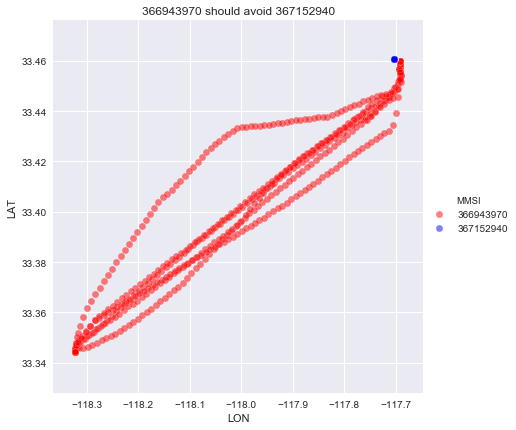

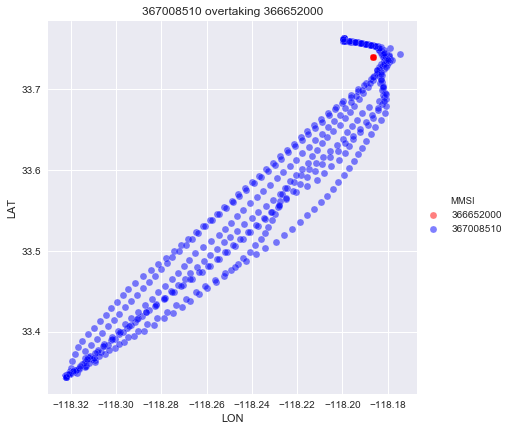

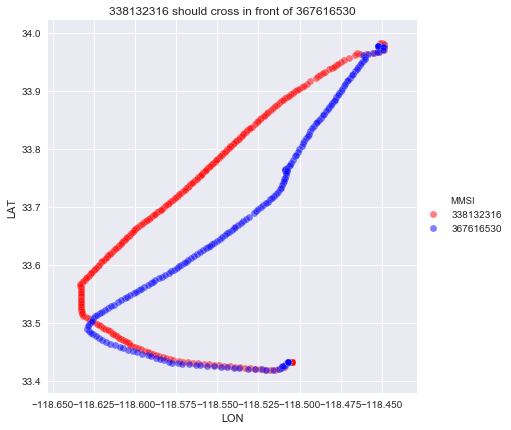

In [58]:
for pair in random.sample(potential_collisions,3):
    plot_interaction(pair)

In [59]:
analysis_time_in_minutes = round((dt.datetime.now() - start_analysis_time).total_seconds()/60,1)
print('Full analysis took {} minutes'.format(analysis_time_in_minutes))

Full analysis took 10.4 minutes


# TODO:
- remove tugboats
- interaction plot (seaborn)
- interactive interaction plot with time slider (bokeh)
- identify future behavior of potential collision ships to identify potential COLREGS violations